In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#用于评价报告

In [16]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [17]:
x = data['X']
y = data['y']

x.shape, y.shape

((5000, 400), (5000, 1))

In [18]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  #(5000,1)
    y = y.reshape(y.shape[0]) #make it back to column vector

    X = data.get('X') #(5000,400)

    if transpose:
        #for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape(20,20).T for im in X])

        #再次将图像扁平化来保留矢量呈现
        X = np.array([im.reshape(400) for im in X])
    
    
    return X, y

In [19]:
X, y = load_data('ex4data1.mat')

print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [20]:
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1,1))
    ax.matshow(image.reshape(20,20), cmap='binary')
    plt.xticks([]) #消除横纵坐标
    plt.yticks([])

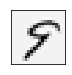

this should be 9


In [21]:
pick_one = np.random.randint(0,5000)
plot_an_image(X[pick_one])
plt.show()
print('this should be {}'.format(y[pick_one]))

In [22]:
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1]))

    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_image = X[sample_idx]

    #sharex sharey共享x轴和y轴
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(10,10))

    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_image[10*r+c].reshape(size, size),
                                                        cmap='binary')
            plt.xticks([])
            plt.yticks([])
                                                    


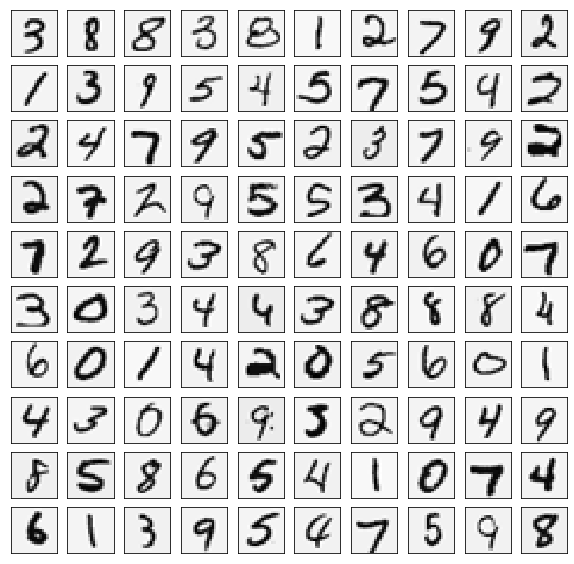

In [23]:
plot_100_image(X)
plt.show()

In [24]:
X = data['X']
y = data['y']

X.shape, y.shape#看下维度

((5000, 400), (5000, 1))

需要对y标签进行一次one-hot编码，one-hot编码将类标签n（k类）转换为长度为k的向量，其中索引n为“hot”(1),而其余为0。

In [25]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False) #不加sparse=False则按照标签命定义0-k
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [26]:
y[0],y_onehot[0]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

为此练习构建的神经网络具有与我们的实例数据（400+偏置单元）大小匹配的输入层，25个单位的隐藏层（带有偏执单元26个），以及一个输出层，10个单位对应一个one-hot编码类标签。

In [27]:

def sigmoid(z):
    return 1/(1+np.exp(-z))

# 前向传播函数
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: left;" src="nn_model.png">

In [28]:
def forward_propagate(X, theta1, theta2):
    m  = X.shape[0]

    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 @ theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 @ theta2.T
    h = sigmoid(z3)

    return a1, z2 , a2, z3, h

# 代价函数
<img style="float: left;" src="nn_cost.png">

In [29]:
def cost(params, input_size, hidden_size, num_labels,X, y_onehot, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y_onehot = np.matrix(y_onehot)
    
    #将对应层的参数数组转换为矩阵 这里是将两层的theta都放入params中，然后按照个数来划分theta1和theta2
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)], (hidden_size, (input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):], (num_labels,(hidden_size+1))))

    #调用forward_propagate
    a1, z3, a2 ,z3, h = forward_propagate(X, theta1, theta2)

    #计算代价
    J = 0
    for i in range(m):
        #因为y_onehot为m*10的矩阵，每个h为 1*10的矩阵
        first_term = -y_onehot[i,:] @ np.log(h[i,:]).T
        second_term = (1 - y_onehot[i,:]) @ np.log(1 - h[i,:]).T
        J += np.sum(first_term - second_term)
    
    J  = J / m

    return J

前向传播函数计算给定当前参数的每个训练实例的假设。它的输出形状应该与y的一个one-hot编码相同

In [30]:
#初始化设置
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

#随机初始化完整网络参数大小的参数数组 默认范围0-1，此处将范围改为-0.5-0.5，然后再缩小为原来的1/4
params = (np.random.random(size=hidden_size*(input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

#将参数数组解开为每个层的参数矩阵
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [31]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

代价函数在计算假设矩阵h之后，应用代价函数来计算y和h之间的总误差

In [32]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

7.398319421149904

# 正则化代价函数
我们的下一步是增加代价函数的正则化。  它实际上并不像看起来那么复杂 - 事实上，正则化术语只是我们已经计算出的代价的一个补充。 下面是修改后的代价函数。
<img style="float: left;" src="nn_regcost.png">

In [33]:
def cost1(params, input_size, hidden_size, num_labels,X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    #将对应层的参数数组转换为矩阵 这里是将两层的theta都放入params中，然后按照个数来划分theta1和theta2
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)], (hidden_size, (input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):], (num_labels,(hidden_size+1))))

    #调用forward_propagate
    a1, z3, a2 ,z3, h = forward_propagate(X, theta1, theta2)

    #计算代价
    J = 0
    for i in range(m):
        #因为y为m*10的矩阵，每个h为 1*10的矩阵
        first_term = -y[i,:] @ np.log(h[i,:]).T
        second_term = (1 - y[i,:]) @ np.log(1 - h[i,:]).T
        J += np.sum(first_term-second_term)
    
    J  = J / m

    #添加正则化部分
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:, 1:],2)))
    

    return J

In [34]:
cost1(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

7.40359670203761

接下来是反向传播算法。 反向传播参数更新计算将减少训练数据上的网络误差。 我们需要的第一件事是计算我们之前创建的Sigmoid函数的梯度的函数，即对sigmoid函数求导。

In [35]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

利用反向传播来计算梯度。由于反向传播所需要的计算是代价函数中所需的计算过程，实际上可以扩展代价函数以执行反向传播并返回代价和梯度。

In [36]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    #将对应层的参数数组转换为矩阵 这里是将两层的theta都放入params中，然后按照个数来划分theta1和theta2
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size+1)], (hidden_size, (input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):], (num_labels,(hidden_size+1))))

    #调用forward_propagate
    a1, z2, a2 ,z3, h = forward_propagate(X, theta1, theta2)

    #初始化
    J = 0
    delta1 = np.zeros(theta1.shape) #(25, 401)
    delta2 = np.zeros(theta2.shape) #(10, 26)

    #计算代价
    for i in range(m):
        #因为y为m*10的矩阵，每个h为 1*10的矩阵
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term-second_term)
    
    J  = J / m

    #添加正则化部分
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:, 1:],2)))

    #实现反向传播
    for t in range(m):
        a1t = a1[t,:] #(1, 401)
        z2t = z2[t,:] #(1, 25)
        a2t = a2[t,:] #(1, 26)
        ht = h[t,:] #(1,10)
        yt = y[t,:] #(1,10)
        
        d3t = ht - yt  #(1, 10) 此处的ht不需要sigmoid，所以少了个sigmoid求导O(1-O)
                                      
        z2t = np.insert(z2t, 0, values=np.ones(1)) #(1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t)) #(1, 26) theta2为第二层权重(W<2>),sigmoid_gradient(z2t)即O<2>(1-O<2>) <>中表示层

        delta1 = delta1 + (d2t[:,1:]).T * a1t #a1t为第二层的输入   偏置项的梯度恒为0
        delta2 = delta2 + d3t.T * a2t   #a2t为第三层的输入

    delta1 = delta1 / m
    delta2 = delta2 / m 

    #将梯度矩阵转换为一维数组
    grad = np.concatenate((np.ravel(delta1),np.ravel(delta2)))
    
    return J , grad



反向传播计算的最难的部分（除了理解为什么我们正在做所有这些计算）是获得正确矩阵维度。 顺便说一下，你容易混淆了A * B与np.multiply（A，B）使用。 基本上前者是矩阵乘法，后者是元素乘法（除非A或B是标量值，在这种情况下没关系）。
无论如何，让我们测试一下，以确保函数返回我们期望的。

In [37]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(7.40359670203761, (10285,))

将梯度计算加正则化

In [38]:
def backprop_regularization(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    #将对应层的参数数组转换为矩阵 这里是将两层的theta都放入params中，然后按照个数来划分theta1和theta2
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    #调用forward_propagate
    a1, z2, a2 ,z3, h = forward_propagate(X, theta1, theta2)

    #初始化
    J = 0
    delta1 = np.zeros(theta1.shape) #(25, 401)
    delta2 = np.zeros(theta2.shape) #(10, 26)

    #计算代价
    for i in range(m):
        #因为y为m*10的矩阵，每个h为 1*10的矩阵
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term-second_term)
    
    J  = J / m

    #添加正则化部分
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:, 1:],2)))

    #实现反向传播
    for t in range(m):
        a1t = a1[t,:] #(1, 401)
        z2t = z2[t,:] #(1, 25)
        a2t = a2[t,:] #(1, 26)
        ht = h[t,:] #(1,10)
        yt = y[t,:] #(1,10)
        
        d3t = ht - yt  #(1, 10) 此处的ht不需要sigmoid，所以少了个sigmoid求导O(1-O)
                                      
        z2t = np.insert(z2t, 0, values=np.ones(1)) #(1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t)) #(1, 26) theta2为第二层权重(W<2>),sigmoid_gradient(z2t)即O<2>(1-O<2>) <>中表示层

        delta1 = delta1 + (d2t[:,1:]).T * a1t #a1t为第二层的输入   偏置项的梯度恒为0
        delta2 = delta2 + d3t.T * a2t   #a2t为第三层的输入

    delta1 = delta1 / m
    delta2 = delta2 / m 

    #添加梯度正则化项
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m

    #将梯度矩阵转换为一维数组
    grad = np.concatenate((np.ravel(delta1),np.ravel(delta2)))
    
    return J , grad

In [39]:
J, grad = backprop_regularization(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(7.40359670203761, (10285,))

In [40]:
from scipy.optimize import minimize

#优化梯度函数
fmin = minimize(fun=backprop_regularization, x0=params,args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate),
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.3473922294549113
     jac: array([-1.97473533e-04, -1.50858891e-07,  3.27850863e-08, ...,
        9.66187897e-05,  1.76070723e-04,  2.25605426e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 23
  status: 3
 success: False
       x: array([-6.11375072e-01, -7.54294457e-04,  1.63925431e-04, ...,
        9.52027439e-01,  1.91312069e+00,  1.50383884e-01])

由于目标函数不太可能收敛，所以对迭代次数进行限制。总代价已经降到0.5以下，这是算法正常工作的一个很好的指标。

In [41]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1) #取出h中元素最大的索引
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [43]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 99.06%


与exp3相比，反向传播算法比多分类梯度下降的准确率要高一些。